In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import sqrt, exp, sinh, conj, absolute, pi
from scipy import constants, special
plt.rcParams['figure.figsize'] = 16, 9

We use atomic units; all wave functions are represented such that $u[i]$ is the value at the $i$-th bin; normalization then corresponds to $\lVert u \rVert_{L^2}^2 = dx \sum_i u[i]^2 = 1$.

# (a) Schrödinger Solver

### Numerov Integration (from solution to exercise 3.2)

Integrate $-\psi''(x) = k(x) \psi(x)$.

In [3]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """compute psi2 via a single numerov step"""
    dx_sqr = dx**2
    c0 = (1 + 1/12. * dx_sqr * k0)
    c1 = 2 * (1 - 5/12. * dx_sqr * k1)
    c2 = (1 + 1/12. * dx_sqr * k2)
    return (c1 * psi1 - c0 * psi0) / c2

def numerov(ks, psi0, psi1, dx):
    """compute psi = [psi0, psi1, psi2, ...] for ks = [k0, k1, k2, ...] via iterated numerov steps"""
    psi = np.zeros_like(ks)
    psi[0] = psi0
    psi[1] = psi1
    for i in range(2, len(ks)):
        psi[i] = numerov_step(ks[i-2], ks[i-1], ks[i], psi[i-2], psi[i-1], dx)
    return psi

### Radial Schrödinger Solver (adapted from solution to exercise 2.1)

Find ground state for radial Schrödinger equation $-\frac 1 2 u''(r) + V(r) u(r) = E u(r)$.

In [14]:
r_min = 0
r_max = 20
r_steps = 50000
rs, dr = np.linspace(r_min, r_max, r_steps + 1, retstep=True)
r_min, rs = rs[1], rs[1:]  # skip r=0

def solve_schrodinger(Vs, E_min=-10, E_max=0, maxiter=100, stoptol = 0.0001, verbose=False, retnumiter=False):
    """returns ground state energy, ground state wave function, and -- optionally -- the number of numerov iterations that were required"""
    for i in range(maxiter):
        E = (E_min + E_max) / 2.
        if verbose:
            print("%02d: trying E = %f in [%f, %f]" % (i + 1, E, E_min, E_max),)
        
        # numerov integration starting from r*exp(-r) at r_max to r_min
        ks = 2 * (E - Vs)
        psi_last = rs[-1] * exp(-rs[-1])
        psi_2nd_last = rs[-2] * exp(-rs[-2])
        u = numerov(ks[::-1], psi_last, psi_2nd_last, dr)
        u = u[::-1]
        num_nodes = np.sum(u[1:] * u[:-1] < 0)
        if verbose:
            print(', u(0) = %f, #nodes = %d' % (u[0], num_nodes))
        
        # bisect       
        if num_nodes == 0 and absolute(u[0]) <= stoptol:
            if verbose:
                print("  -> converged after", i + 1, "iterations: E_0 =", E)
            return (E, u, i+1) if retnumiter else (E, u)
        if num_nodes == 0 and u[0] > 0:
            E_min = E
        else:
            assert num_nodes > 0, "expect #nodes > 0 since u[0] < 0 while u[infty] > 0"
            E_max = E
    
    raise Exception("Not converged after %d iterations; u(0) = %f" % (maxiter, u[0]))

E, u = solve_schrodinger(-1./rs, verbose=True)

01: trying E = -5.000000 in [-10.000000, 0.000000]
, u(0) = 12884645614632673280.000000, #nodes = 0
02: trying E = -2.500000 in [-5.000000, 0.000000]
, u(0) = 65058210171.040329, #nodes = 0
03: trying E = -1.250000 in [-2.500000, 0.000000]
, u(0) = 54164.193034, #nodes = 0
04: trying E = -0.625000 in [-1.250000, 0.000000]
, u(0) = 0.750139, #nodes = 0
05: trying E = -0.312500 in [-0.625000, 0.000000]
, u(0) = -0.000956, #nodes = 1
06: trying E = -0.468750 in [-0.625000, -0.312500]
, u(0) = -0.007805, #nodes = 1
07: trying E = -0.546875 in [-0.625000, -0.468750]
, u(0) = 0.063054, #nodes = 0
08: trying E = -0.507812 in [-0.546875, -0.468750]
, u(0) = 0.005109, #nodes = 0
09: trying E = -0.488281 in [-0.507812, -0.468750]
, u(0) = -0.004283, #nodes = 1
10: trying E = -0.498047 in [-0.507812, -0.488281]
, u(0) = -0.000560, #nodes = 1
11: trying E = -0.502930 in [-0.507812, -0.498047]
, u(0) = 0.001995, #nodes = 0
12: trying E = -0.500488 in [-0.502930, -0.498047]
, u(0) = 0.000652, #nodes

Compare with exact solution:

In [15]:
E_exact = 0.5
u_exact = rs * exp(-rs)

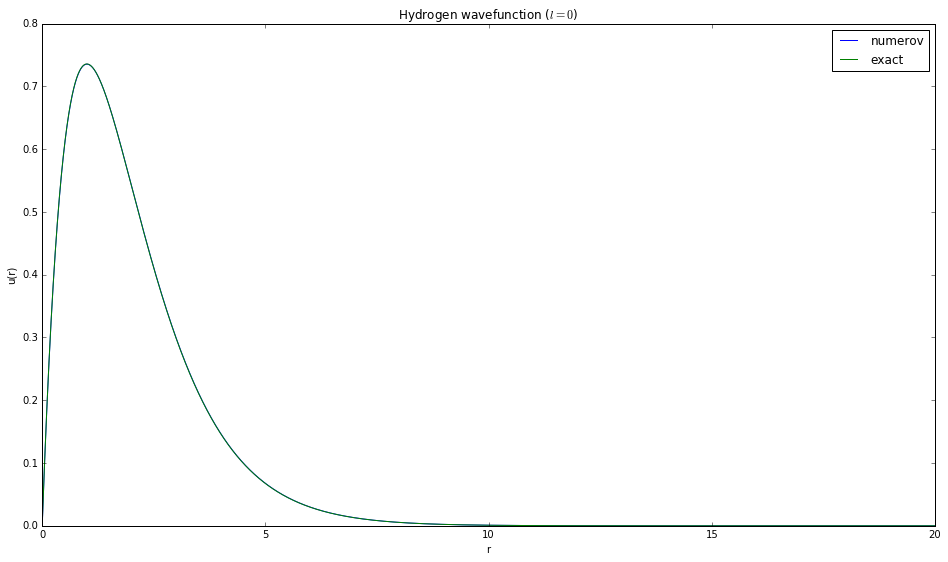

In [6]:
# normalize u & u_exact are the values of a wave function normalized to norm 1
u /= np.linalg.norm(u) * sqrt(dr)
u_exact /= np.linalg.norm(u_exact) * sqrt(dr)

# plot
plt.figure()
plt.title('Hydrogen wavefunction ($l=0$)')
plt.plot(rs, u, label='numerov')
plt.plot(rs, u_exact, label='exact')
plt.xlabel('r')
plt.ylabel('u(r)')
plt.legend(loc='best')
plt.show()

# (b) Poisson Solver

### Verlet Integration

Integrate $U''(x) = f(x)$.

In [7]:
def verlet(fs, U0, U1, dx):
    """compute U = [U0, U1, U2, ...] for fs = [f0, f1, ...] via verlet integration"""
    dx_sqr = dx**2
    U = np.zeros_like(fs)
    U[0] = U0
    U[1] = U1
    for i in range(2, len(fs)):
        U[i] = 2 * U[i-1] - U[i-2] +  fs[i-1] * dx_sqr
    return U

Integrate $U''(r) = -\frac{u^2(r)} {r}$ subject to boundary conditions $U(0) = 0$ and $U(r_{\max}) = 1$.

In [16]:
def solve_poisson(u):
    # start verlet integration from U(0) = 0, U(dx) = dx (can always be extended to a solution, but does not necessarily satisfy the right-hand side boundary condition)
    fs = -u**2 / rs
    U0, U1 = rs[0], rs[1]
    #U0, U1 = 0, dr
    U = verlet(fs, U0, U1, dr)
    
    # fix right-hand side boundary condition
    U = U - (U[-1]-1) / rs[-1] * rs
    return U

U = solve_poisson(u)

Exact solution:

In [17]:
U_exact = -(rs + 1) * exp(-2 * rs) + 1

In [10]:
plt.title('Hartree potential (Hydrogen)')
plt.plot(rs, U, label='verlet')
plt.plot(rs, U_exact, label='exact')
plt.xlabel('r')
plt.ylabel('U(r)')
plt.legend(loc='best')
plt.show()

# (c) Helium

DFT for two electrons with given nuclear potential.

In [20]:
%%time
def two_electron_dft(V_nucl, maxiter=100, stoptol=0.001, verbose=False):
    # initial estimate for u(r) corresponding to V_h = V_xc = 0
    V_hartree = np.zeros_like(V_nucl)
    V_xc = np.zeros_like(V_nucl)
    eps = None
    
    for i in range(maxiter):
        # compute new u(r)
        eps_old = eps
        eps, u, numiter = solve_schrodinger(V_nucl + V_hartree + V_xc, retnumiter=True)
        u /= np.linalg.norm(u) * sqrt(dr)
        if verbose:
            print("%02d: eps = %f, #iterations = %d" % (i, eps, numiter),)

        # converged?        
        if eps_old is not None:
            if verbose:
                print(", |eps - eps_old| = %f" % abs(eps - eps_old))
            if abs(eps - eps_old) < stoptol:
                return 2*eps - dr * np.dot(V_hartree, u**2) - 0.5 * dr * np.dot(V_xc, u**2)
        elif verbose:
            print(" eps_old is none ")

        # update Hartree potential by integration the electron density
        U = solve_poisson(u)
        V_hartree = 2. * U / rs
        
        # update exchange-correlation potential
        #V_xc = -(3. / pi * 2. * u**2 / (rs**2 * 4 * pi)) ** (1./3)
        
        # exchange potential as in equation 8.47 in the notes:
        rhos = (1./3.*2.*u**2/rs**2)**(-1./3.)
        V_xc = -(3./(2.*pi))**(2./3.)*1./rhos*(1.+0.0545*rhos*np.log(1.+11.4/rhos))

    raise Exception("Not converged after %d iterations; |eps - eps_old| = %f" % (maxiter, abs(eps - eps_old)))

print("E = ", two_electron_dft(-2./rs, verbose=True))


00: eps = -1.993684, #iterations = 41
 eps_old is none 
01: eps = -0.393066, #iterations = 12
, |eps - eps_old| = 1.600618
02: eps = -0.672200, #iterations = 22
, |eps - eps_old| = 0.279133
03: eps = -0.545101, #iterations = 19
, |eps - eps_old| = 0.127099
04: eps = -0.596247, #iterations = 20
, |eps - eps_old| = 0.051146
05: eps = -0.574245, #iterations = 19
, |eps - eps_old| = 0.022001
06: eps = -0.583467, #iterations = 20
, |eps - eps_old| = 0.009222
07: eps = -0.579557, #iterations = 20
, |eps - eps_old| = 0.003910
08: eps = -0.581207, #iterations = 16
, |eps - eps_old| = 0.001650
09: eps = -0.580502, #iterations = 19
, |eps - eps_old| = 0.000706
E =  -2.83096625252
CPU times: user 30 s, sys: 53.5 ms, total: 30.1 s
Wall time: 30.1 s


We should obtain $ \epsilon \approx 0.52 \text{ a.u.}$ and $ E \approx 2.72 \text{ a.u.} $  for the exchange potenial used in exercise sheet 10.

The exact value is $ E = -2.903 \text{ a.u.}$  (Computational Physics, J. Thijssen, chapter 4)

Remember from the previous exercise that the Hartree ground state energy is -2.85516035589. 


